In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification, AdamW
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from torch.nn import CrossEntropyLoss
from transformers import get_linear_schedule_with_warmup

In [2]:
!pip install sentencepiece
!wget https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt

--2023-12-02 02:07:47--  https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8002::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 278779 (272K) [text/plain]
Saving to: ‘botchan.txt.3’

botchan.txt.3       100%[===================>] 272.25K  --.-KB/s    in 0.06s   

2023-12-02 02:07:48 (4.78 MB/s) - ‘botchan.txt.3’ saved [278779/278779]



In [3]:
import torch
from transformers import XLNetTokenizer
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, random_split

# Function to preprocess text for XLNet
def preprocess_for_xlnet(texts, tokenizer, max_len=128):
    encoded_batch = tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoded_batch['input_ids'], encoded_batch['attention_mask']
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')

# Assuming you have a CSV file with 'content' and 'category' columns
df = pd.read_csv('/Users/bhavikpatel/Desktop/poject MSDA/Data 270/project/gwar project data/data.csv')
df['content'] = df['content'].astype(str)

# Sample 10000 rows from the DataFrame
df_sampled = df.sample(n=100000, random_state=42)

# Preprocess the sampled data
input_ids, attention_masks = preprocess_for_xlnet(df_sampled['content'].tolist(), tokenizer)

# Convert labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df_sampled['category'])

# Stratified split of the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df_sampled['content'], labels, random_state=42, test_size=0.2, stratify=labels)

# Split the temp set into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, random_state=42, test_size=0.5, stratify=temp_labels)

# Preprocess text data
train_input_ids, train_attention_masks = preprocess_for_xlnet(train_texts.tolist(), tokenizer)
val_input_ids, val_attention_masks = preprocess_for_xlnet(val_texts.tolist(), tokenizer)
test_input_ids, test_attention_masks = preprocess_for_xlnet(test_texts.tolist(), tokenizer)

# Create Tensor datasets
train_dataset = TensorDataset(train_input_ids, train_attention_masks, torch.tensor(train_labels))
val_dataset = TensorDataset(val_input_ids, val_attention_masks, torch.tensor(val_labels))
test_dataset = TensorDataset(test_input_ids, test_attention_masks, torch.tensor(test_labels))

print("Data loaded and preprocessed with stratified split.")

Loading XLNet tokenizer...
Loading and preprocessing dataset...
Data loaded and preprocessed with stratified split.


In [4]:
# Efficient Data Loading
batch_size = 16
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=2)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, num_workers=2)

print("DataLoaders are set up.")

DataLoaders are set up.


In [5]:

# Initialize XLNet model
print("Initializing XLNet model...")
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)  # 3 labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)

print("Model and optimizer are initialized.")

# Calculate class weights for CrossEntropyLoss
class_counts = df['category'].value_counts()
class_weights = 1. / class_counts
weights = class_weights[label_encoder.transform(df['category'].unique())]
weights = torch.tensor(weights, dtype=torch.float).to(device)


Initializing XLNet model...


Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model and optimizer are initialized.


/Users/bhavikpatel/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [6]:
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=3)  # 3 labels
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
class_counts = df['category'].value_counts()
class_weights = 1. / class_counts
weights = class_weights[label_encoder.transform(df['category'].unique())]
weights = torch.tensor(weights, dtype=torch.float).to(device)
# Early Stopping Setup
accumulation_steps = 4
early_stopping_patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0
epochs = 4  # Adjust as needed
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []
val_preds = []
val_labels = []
for epoch_i in range(epochs):
    # Training phase with gradient accumulation
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    for step, batch in tqdm(enumerate(train_loader), total=len(train_loader)):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        optimizer.zero_grad()

        # Automatic mixed precision
        outputs = model(input_ids=b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss / accumulation_steps

        loss.backward()

        if (step + 1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Calculate training accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == b_labels).sum().item()
        total += b_labels.size(0)

    train_accuracy = total_correct / total
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch_i + 1}/{epochs} Training Accuracy: {train_accuracy}")
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_eval_loss, total_correct, total = 0, 0, 0
    all_preds, all_labels = [], []
    for batch in tqdm(val_loader, desc="Validating"):
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss.item()
        total_eval_loss += loss

        # For accuracy and confusion matrix
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == b_labels).sum().item()
        total += b_labels.size(0)
        all_preds.extend(predictions.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

    val_accuracy = total_correct / total
    val_accuracies.append(val_accuracy)
    avg_val_loss = total_eval_loss / len(val_loader)
    print(f"Epoch {epoch_i + 1}/{epochs} Validation Accuracy: {val_accuracy}")
    avg_val_loss = total_eval_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stopping_patience:
            print("Early stopping triggered.")
            break

print("Training and validation completed.")

Starting training loop...


100%|█████████████████████████████████████| 5000/5000 [2:55:49<00:00,  2.11s/it]


Epoch 1/4 Training Accuracy: 0.695575


Validating: 100%|█████████████████████████████| 625/625 [05:56<00:00,  1.75it/s]

Epoch 1/4 Validation Accuracy: 0.7624



100%|█████████████████████████████████████| 5000/5000 [2:57:05<00:00,  2.13s/it]


Epoch 2/4 Training Accuracy: 0.7599


Validating: 100%|█████████████████████████████| 625/625 [05:47<00:00,  1.80it/s]

Epoch 2/4 Validation Accuracy: 0.7811



100%|█████████████████████████████████████| 5000/5000 [2:56:32<00:00,  2.12s/it]


Epoch 3/4 Training Accuracy: 0.774275


Validating: 100%|█████████████████████████████| 625/625 [05:46<00:00,  1.80it/s]

Epoch 3/4 Validation Accuracy: 0.7841



100%|█████████████████████████████████████| 5000/5000 [2:56:51<00:00,  2.12s/it]


Epoch 4/4 Training Accuracy: 0.79085


Validating: 100%|█████████████████████████████| 625/625 [05:48<00:00,  1.79it/s]

Epoch 4/4 Validation Accuracy: 0.7929
Training and validation completed.


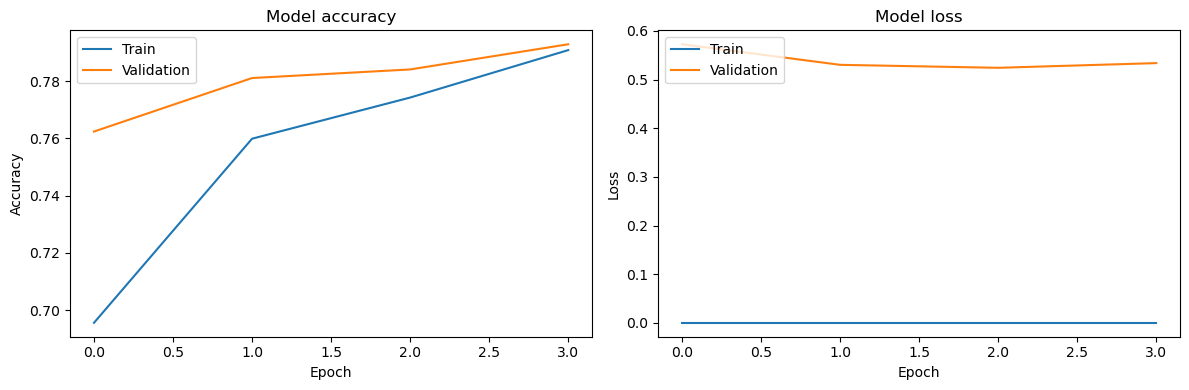

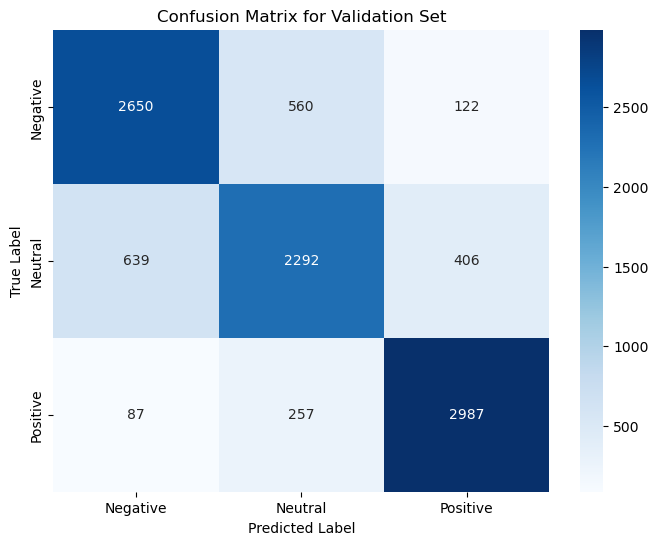

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (rest of your code)

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train')
plt.plot(val_accuracies, label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Calculate and plot confusion matrix for validation set
val_conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [8]:
#torch.save(model.state_dict(), 'xlnet_model_state.pth')


In [9]:
import numpy as np

np.save('predictions.npy', np.array(all_preds))
np.save('actual_labels.npy', np.array(all_labels))


In [10]:
np.save('train_accuracies.npy', np.array(train_accuracies))
np.save('val_accuracies.npy', np.array(val_accuracies))


In [11]:
## the model is saved to other folder
model.load_state_dict(torch.load('xlnet_model_state.pth'))


<All keys matched successfully>

In [12]:
from torch.utils.data import DataLoader, SequentialSampler


In [13]:
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Create DataLoaders
batch_size = 32  # You can adjust the batch size as needed

test_dataloader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=batch_size
)

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict 
for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

# Calculate evaluation metrics
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')


Accuracy: 0.782
F1 Score: 0.7799401608673616
Precision: 0.7792936540835984
Recall: 0.782
